# TP 1 (Mariano)
## 0. Preparo data
## 1. Target vs largo (caracteres)
## 2. Target vs keywords [DE DONDE SALEN LAS KEYWORDS???]
## 3. Target vs text (palabras)

# HACER:
## 4. Keywords vs text (palabras)

# Introducción
Presentamos en este informe un análisis exploratorio del set de datos publicado en https://www.kaggle.com/c/nlp-getting-started. El set corresponde a una clasificación de tweets cuyo contenido (variable text) se relaciona con la posible ocurrencia de un hecho desgraciado. Se divide en dos subsets: el primero (train) posee una clasificación a posteriori (target) que indica si realmente ocurrió el desastre que se menciona en el tweet (target = 1) o no (target = 0). El segundo subset (test) carece de tal clasificación. Ambos poseen además un código de identificación (id), e información sobre tipo de evento (keyword) y lugar (location). Nuestro análisis tiene en cuenta el objetivo del desafío de kaggle y el del segunto TP de la materia: entrenar un algoritmo con el set train para poder predecir si los tweets del set test están asociados a catástrofes reales o no.


#  
# 0. Preparo data
#### En primer lugar, revisamos el set de datos para entender cómo están estructurados y si existen anomalías. 

## 0.1. Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats.mstats as sp
%matplotlib inline

## 0.2. Cargo data

In [31]:
train = pd.read_csv('train.csv')#, encoding='latin_1')
test = pd.read_csv('test.csv')
#ss = pd.read_csv('sample_submission.csv')

## 0.3. Revisamos los datos.
### 0.3.1. Set de datos train
Comenzamos chequeando el dataset train: tamaño, tipo de datos y cantidad de nulos.

In [32]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Vemos que se trata de una muestra de un dataset más grande pues los valores de id no coinciden con los valores del índice. Además, ya se observa que al menos keyword y location poseen nulos.

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [34]:
7552*100/7613, 5080*100/7613

(99.19873899908052, 66.72796532247472)

Keyword presenta cerca de un 1% de nulos, location cerca de 33%, el resto ninguno. Keyword, location y text son objetos con texto, las otras dos variables constan de enteros.

In [35]:
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


    Una estadística descriptiva inicial revela que en keyword se encuentran sólo 221 valores únicos, con los cual podría transformarse en una variable categórica si el especio en memoria fuera un problema, pero no es el caso. El valor que aparece con mayor frecuencia es "fatalities", pero con solo 45 casos, lo cual sugiere que las keywords se reparten bastante uniformemente respecto de los tweets. Nos preguntamos, ¿cómo fue generada esta variable? ¿Con qué criterio se asignó cada keyword a cada tweet? ¿Los términos fueron tomados del texto de los tweets? En Kaggle no figuran las respuestas a estas preguntas. Sölo se menciona el origen de los datos, pero ya no se los encuentra en la página de internet que citan como fuente (www.XXXXXXXX). Una búsqueda en google (XXXXXXXX primeros resultados) no nos disipa la duda.
    Por su parte, la variable location cuenta con 3341 valores únicos, y su valor más frecuente es USA, con 104 ocurrencias. En principio parece que las ubicaciones son muy variables.
    Respecto de text notamos, al comparar valores únicos con el tamaño de la muestra, que cerca de 100 tweets se encuentran repetidos, siendo el más repetido (10 veces) el que se observa en la Tabla X. Más adelante analizaremos algunos de estos tweets en particular.
    La clasificación de los teewts según la variable target ha sido realizada para el total de ellos. La media indica que cerca del 43% de los tweets corresponde con una emergencia real, es decir que ambas categorías están representadas de manera pareja bastante pareja.

### 0.3.1. Set de datos test
Realizamos similar análisis chequeando el dataset de testeo (test).

In [36]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [38]:
test.describe(include='all')

,id,keyword,location,text
count,3263.000000,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.152927,NaN,NaN,NaN
std,3146.427221,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,2683.000000,NaN,NaN,NaN
50%,5500.000000,NaN,NaN,NaN
75%,8176.000000,NaN,NaN,NaN


En este caso, vemos que la gran mayoría de los tweets tienen asignada una keyword, no asi una location. Las keywords son, nuevamente, 221 en total, lo que sugiere chequear que sean las mismas. 

In [39]:
train['keyword'].drop_duplicates().isin(test['keyword'].drop_duplicates()).value_counts()

True    222
Name: keyword, dtype: int64

Efectivamente, son las mismas.
Respecto del resto de las variables, el análisis es similar al de train, salvo para el valor más frecuente de location. LLama la atención que en train sea un país (USA), y en test una ciudad (New York). Esto merece un análisis más pormenorizado, con el objeto de ver si es necesario, en la medida de lo posible, estandarizar location, de modo de tener sólo ciudades, países, o lo que más convenga.

Pasaremos a analizar la distribución de las variables independientemente del target.

# X. Distribuciones de las variables
## X.1. Keywords
En la Figura X tenemos un pantallazo general de la distribución de todas las keywords. En general su frecuencia se encuentra distribuida de manera pareja entre las 30 y las 40 ocurrencias, con un mínimo de 9 y un máximo de 45. 

In [43]:
kw_histo = train['keyword'].value_counts()
kw_histo.describe()

count    221.000000
mean      34.171946
std        4.786091
min        9.000000
25%       33.000000
50%       35.000000
75%       37.000000
max       45.000000
Name: keyword, dtype: float64

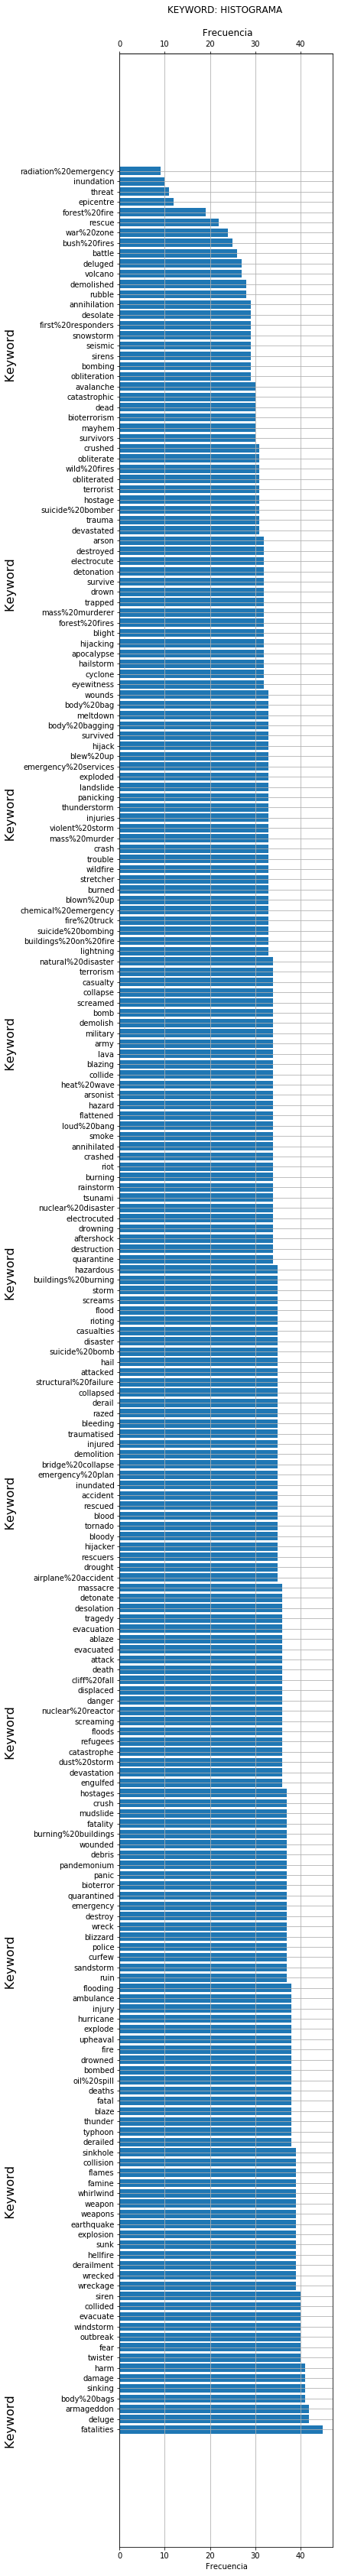

In [45]:
fig = plt.figure(figsize=(5,60))
ax1 = fig.add_subplot()
ax1.barh(kw_histo.index, kw_histo)
ax1.grid()
ax1.set_title('KEYWORD: HISTOGRAMA \n\n Frecuencia')#, fontsize=16)
ax1.secondary_xaxis('top')
ax1.set_xlabel('Frecuencia')
ax1.set_ylabel(('Keyword'+' '*45)*10, fontsize=16);

Comparando los 10 términos con mayor y menor frecuencia, parece haber cierta tendencia a que los primeros sean más genéricos, es decir que podrían asociarse a una gran variedad de tipos de evento; mientras que los segundos suelen referir más específicamente a cierto tipo de evento. En la Tabla X presentamos una clasificación preliminar de los 10 términos más frecuentes y los 10 menos frecuentes. Haría falta un análisis estadístico más profundo para confirmar esta tendencia.

In [69]:
pd.DataFrame({'Kewyords Más Frecuentes': kw_histo.index[:10],
              'KMF tipo de término': ['genérico','específico','genérico','genérico','específico',
                                      'genérico','genérico','específico','genérico','específico'],
              'Kewyords menos Frecuentes': kw_histo.index[-10:],
              'KmF tipo de término': ['específico','específico','específico','específico','genérico',
                                      'específico','específico','genérico','específico','específico']})

,Kewyords Más Frecuentes,KMF tipo de término,Kewyords menos Frecuentes,KmF tipo de término
0,fatalities,genérico,deluged,específico
1,deluge,específico,battle,específico
2,armageddon,genérico,bush%20fires,específico
3,body%20bags,genérico,war%20zone,específico
4,sinking,específico,rescue,genérico
5,damage,genérico,forest%20fire,específico
6,harm,genérico,epicentre,específico
7,twister,específico,threat,genérico
8,fear,genérico,inundation,específico
9,outbreak,específico,radiation%20emergency,específico


#  
## X.2. Location: JORGE
#  

## X.3. Text
Esta es la variable más compleja. Analizaremos los textos de los tweets desde distintas perspectivas: cantidad de caracteres, cantidad de palabras, y luego separaremos los textos en palabras individuales para buscar correlaciones entre ellas.

In [76]:
# Añadimos la variable 'caracteres' para registrar la cantidad de ellos en cada tweet.
train['caracteres'] = train['text'].str.len()
train.sort_values(by='caracteres', inplace=True)
train

,id,keyword,location,text,target,caracteres
4890,6962,massacre,NaN,Bad day,0,7
5115,7295,nuclear%20reactor,NaN,Err:509,0,7
1882,2703,crushed,NaN,Crushed,0,7
24,36,NaN,NaN,LOOOOOOL,0,8
3670,5224,fatality,Rafael castillo,fatality,0,8
...,...,...,...,...,...,...
633,915,bioterrorism,NaN,@HowardU If 90BLKs&amp;8WHTs colluded 2 take W...,1,150
635,919,bioterrorism,NaN,@cspanwj If 90BLKs&amp;8WHTs colluded 2 take W...,1,150
614,885,bioterrorism,NaN,@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT...,1,151
4801,6833,loud%20bang,london essex england uk,It's was about 2:30 in the morning&amp;I went ...,0,152


In [77]:
train_split = train['text'].str.split()
# chequeo: train.sort_values(by='largo')
train_split

4890                                           [Bad, day]
5115                                            [Err:509]
1882                                            [Crushed]
24                                             [LOOOOOOL]
3670                                           [fatality]
                              ...                        
633     [@HowardU, If, 90BLKs&amp;8WHTs, colluded, 2, ...
635     [@cspanwj, If, 90BLKs&amp;8WHTs, colluded, 2, ...
614     [@CAgov, If, 90BLKs&amp;8WHTs, colluded, 2, ta...
4801    [It's, was, about, 2:30, in, the, morning&amp;...
1270    [when, you're, taking, a, shower, and, someone...
Name: text, Length: 7613, dtype: object

# 1. Target vs largo (caracteres)
## 1.1. Train. Distribución largo tweet

In [13]:
# Creo columna con longitud de cada texto
train['largo'] = train['text'].str.len()
train_split = train['text'].str.split()
# chequeo: train.sort_values(by='largo')
train_split

In [13]:
# Agrupo por target
grouped = train.groupby(['target'])
# chequeo estadísticos: grouped.agg({'largo':'describe'}) 

### Grafico

Text(0.5, 0.98, 'TRAIN')

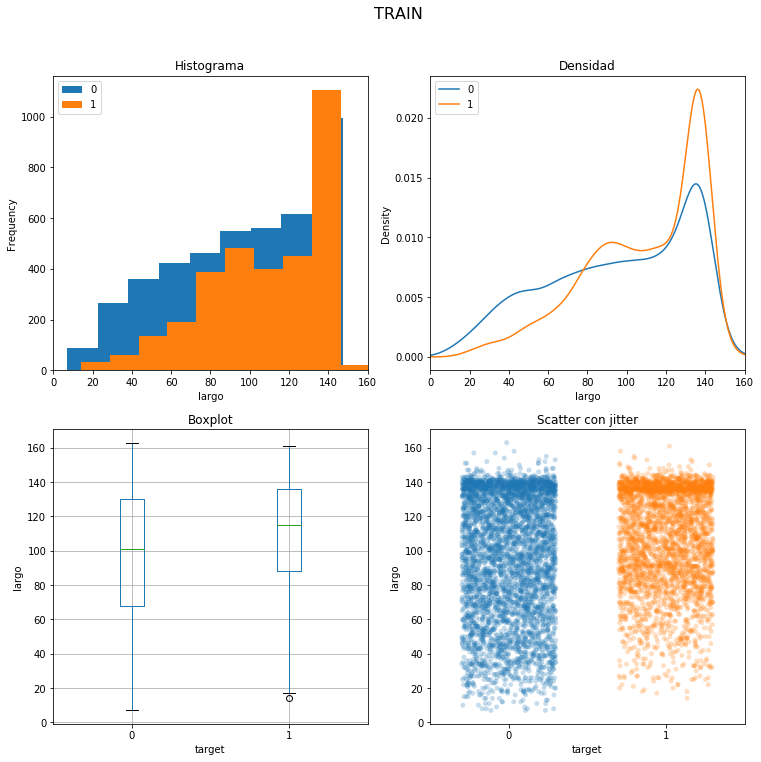

In [14]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
grouped['largo'].plot(
    kind='hist', title='Histograma', legend=True, xlim=(0, 160), figsize=(12,12))
ax1.set_xlabel('largo')

ax2 = fig.add_subplot(222)
grouped['largo'].plot(
    x='largo', kind='kde', title='Densidad', legend=True, xlim=(0, 160), figsize=(12,12))
ax2.set_xlabel('largo')

ax3 = fig.add_subplot(223)
train.boxplot(
    by='target', column='largo', ax=ax3, figsize=(12,12))
ax3.set_title('Boxplot'), ax3.set_xlabel('target'), ax3.set_ylabel('largo')

ax4 = fig.add_subplot(224)
sns.stripplot(x='target',y='largo', data=train, alpha=0.25, jitter=0.3)#,figsize=(12,8));
ax4.set_title('Scatter con jitter')

fig.suptitle('TRAIN', fontsize=16)
#plt.show()

### Train: distribución sin discriminar

Text(0.5, 0.98, 'TRAIN all')

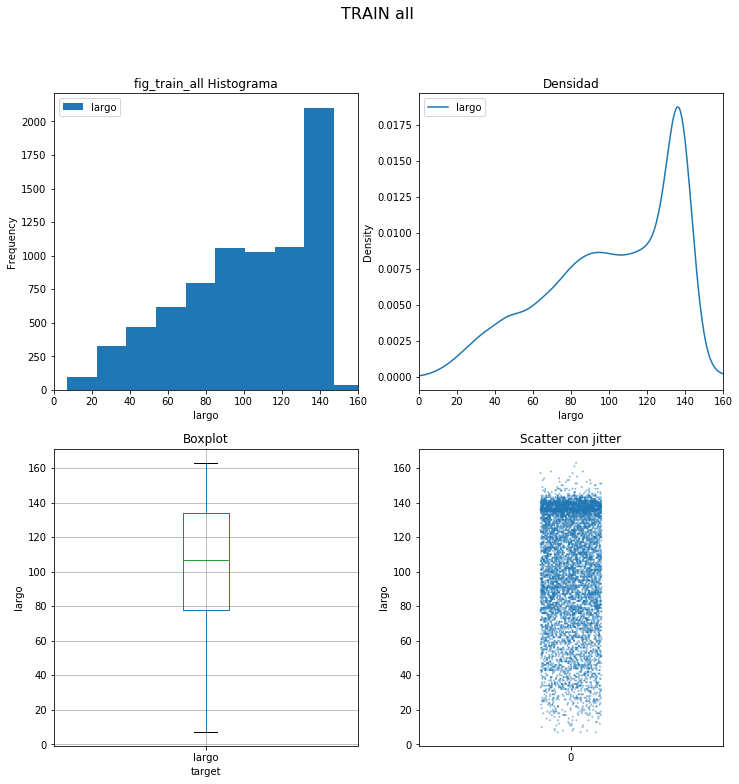

In [15]:
fig_train_all = plt.figure()

fig_train_all_ax1 = fig_train_all.add_subplot(221)
train['largo'].plot(kind='hist', title='fig_train_all Histograma', legend=True, xlim=(0, 160), figsize=(6,6))
fig_train_all_ax1.set_xlabel('largo')

fig_train_all_ax2 = fig_train_all.add_subplot(222)
train['largo'].plot(kind='kde', title='Densidad', legend=True, xlim=(0, 160), figsize=(12,12))
fig_train_all_ax2.set_xlabel('largo')

fig_train_all_ax3 = fig_train_all.add_subplot(223)
train.boxplot(column='largo', ax=fig_train_all_ax3, figsize=(12,12))
fig_train_all_ax3.set_title('Boxplot')
fig_train_all_ax3.set_xlabel('target')
fig_train_all_ax3.set_ylabel('largo')

fig_train_all_ax4 = fig_train_all.add_subplot(224)
sns.stripplot(x=[0]*len(train), y=train['largo'], alpha=0.5, jitter=0.1, size=2)#,figsize=(12,8));data=train['largo'], 
fig_train_all_ax4.set_title('Scatter con jitter')

fig_train_all.suptitle('TRAIN all', fontsize=16)
#plt.show()

## 1.2. TEST. Distribución largo 

In [16]:
# Creo columna con longitud de cada texto
test['largo'] = test['text'].str.len()
# chequeo: test.sort_values(by='largo')
# Agrupo por target
#grouped = test.groupby(['target'])
# chequeo estadísticos: grouped.agg({'largo':'describe'}) 

### Grafico

Text(0.5, 0.98, 'TEST')

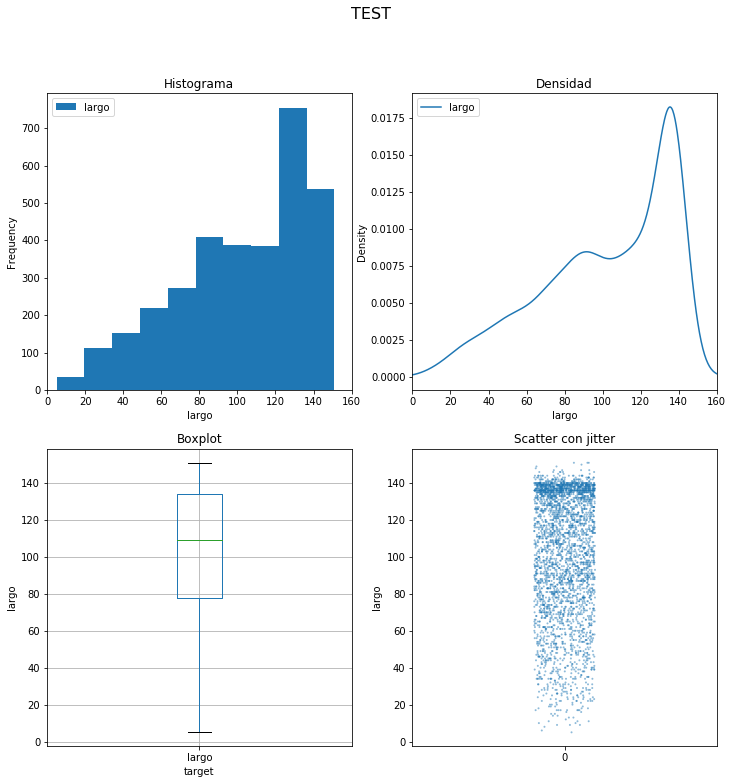

In [17]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
test['largo'].plot(
    kind='hist', title='Histograma', legend=True, xlim=(0, 160), figsize=(12,12))
ax1.set_xlabel('largo')

ax2 = fig.add_subplot(222)
test['largo'].plot(
    x='largo', kind='kde', title='Densidad', legend=True, xlim=(0, 160), figsize=(12,12))
ax2.set_xlabel('largo')

ax3 = fig.add_subplot(223)
test.boxplot(
    column='largo', ax=ax3, figsize=(12,12))
ax3.set_title('Boxplot'), ax3.set_xlabel('target'), ax3.set_ylabel('largo')

ax4 = fig.add_subplot(224)
sns.stripplot(x=[0]*len(test), y='largo', data=test, alpha=0.5, jitter=0.1, size=2)#,figsize=(12,8));
ax4.set_title('Scatter con jitter')

fig.suptitle('TEST', fontsize=16)
#plt.show()

#  
# 2. Target vs keyword
## 2.1. TRAIN.

In [18]:
#train

In [19]:
train['keyword'].fillna('', inplace=True)

In [20]:
#train['keyword'].value_counts()

In [21]:
# Creo columna con longitud de cada texto
# chequeo: train.sort_values(by='largo')

# Agrupo por target
grouped = train.groupby(['target'])
# chequeo estadísticos: grouped.agg({'largo':'describe'}) 
grouped.groups

{0: Int64Index([  15,   16,   17,   18,   19,   20,   21,   22,   23,   24,
             ...
             7576, 7577, 7578, 7579, 7580, 7581, 7582, 7584, 7587, 7593],
            dtype='int64', length=4342),
 1: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612],
            dtype='int64', length=3271)}

## 2.2. Genero matriz para plot barras horiz con fillna(0)

In [22]:
g_unstack = grouped['keyword'].value_counts().unstack().T.fillna(0)
g_unstack['0+1'] = g_unstack[0] + g_unstack[1]
#g_unstack.sort_values(by='0+1')
g_sort_1 = g_unstack.sort_values(by=1)
g_sort_1['delta/suma'] = (g_sort_1[1] - g_sort_1[0]) / (g_sort_1[1] + g_sort_1[0])
#g_sort_1
g_sort_ds = g_sort_1.sort_values(by='delta/suma')

### 2.2.1. Grafico sort by target=1
### histogramas de keyword(target=0),  keyword(target=1), y suma de ambos

Text(0.5, 0, 'target=0 + target=1')

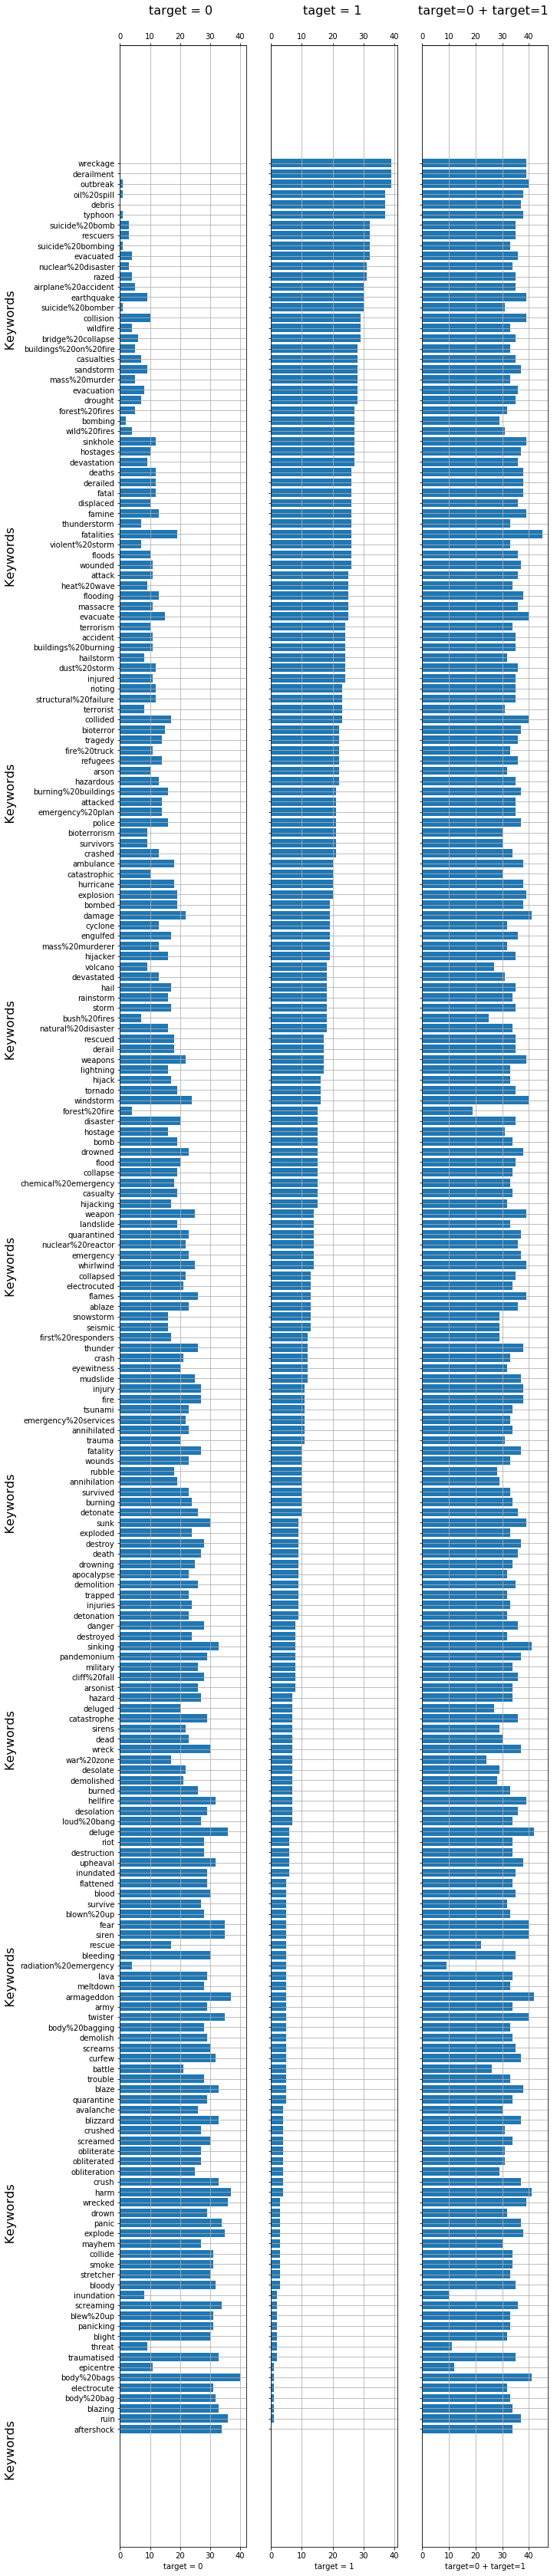

In [79]:
fig = plt.figure(figsize=(10,60))

ax1 = fig.add_subplot(131)
ax1.barh(g_sort_1.index, g_sort_1[0])
ax1.grid()
ax1.set_title('target = 0 \n', fontsize=16)
ax1.secondary_xaxis('top')
ax1.set_ylabel(('Keywords'+' '*45)*10, fontsize=16)
ax1.set_xlabel('target = 0')

ax2 = fig.add_subplot(132)
ax2.barh(g_sort_1.index, g_sort_1[1], tick_label='')
ax2.grid()
ax2.set_title('taget = 1 \n', fontsize=16)
ax2.secondary_xaxis('top')
ax2.set_xlabel('target = 1')

ax3 = fig.add_subplot(133)
ax3.barh(g_sort_1.index, g_sort_1['0+1'], tick_label='')
ax3.grid()
ax3.set_title('target=0 + target=1 \n', fontsize=16)
ax3.secondary_xaxis('top')
ax3.set_xlabel('target=0 + target=1')

### 2.2.2 Grafico sort by delta/suma
### delta/suma = diferencia(cantidad de veces que cada palabra se asocia a target=1 o target=0) / suma(idem)
### Cuanto más cerca delta/suma de 1, más se asocia la palabra a target=1; cuanto más cerca de -1, más se asocia a target=0.

Text(0.5, 0, 'n')

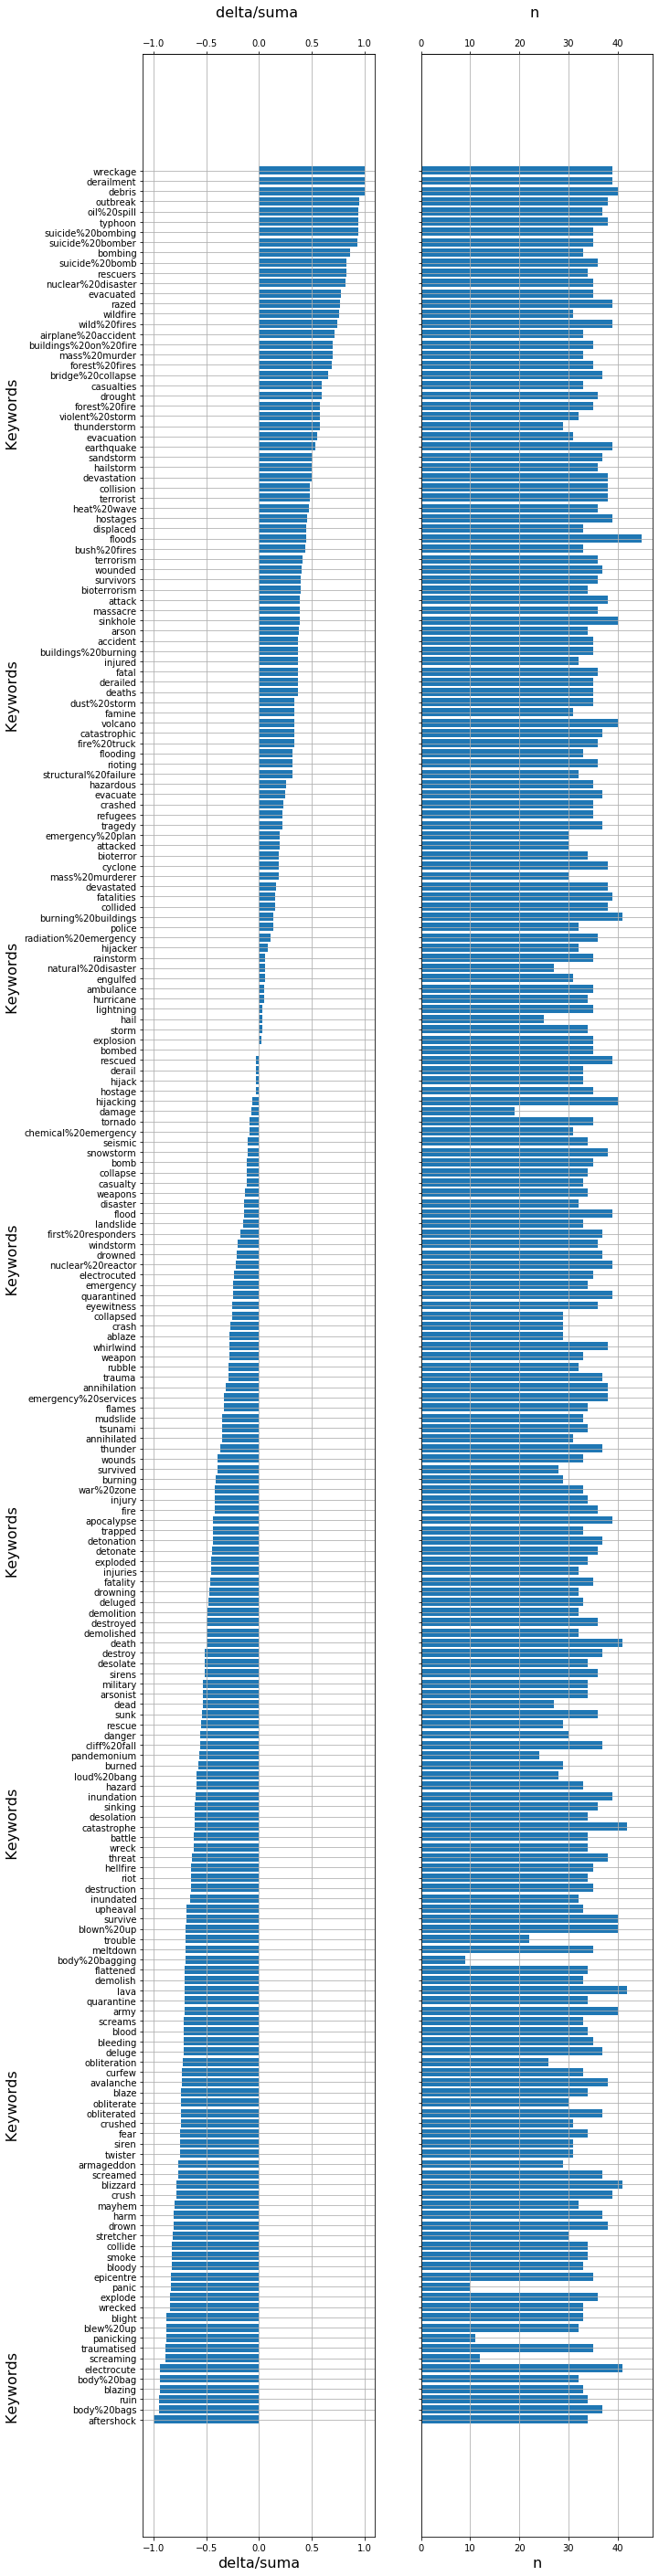

In [80]:
fig = plt.figure(figsize=(10,50))

ax1 = fig.add_subplot(121)
ax1.barh(g_sort_ds.index, g_sort_ds['delta/suma'])
ax1.grid()
ax1.set_title('delta/suma \n', fontsize=16)
ax1.secondary_xaxis('top')
ax1.set_ylabel(('Keywords'+' '*45)*8, fontsize=16)
ax1.set_xlabel('delta/suma', fontsize=16)

ax2 = fig.add_subplot(122)
ax2.barh(g_sort_1.index, g_sort_1['0+1'], tick_label='')
ax2.grid()
ax2.set_title('n \n', fontsize=16)
ax2.secondary_xaxis('top')
ax2.set_xlabel('n', fontsize=16)

#  
# 3. Target vs text (palabras)
## 3.1. mesmo analisis con split de text

In [25]:
texto_split = train['text'].str.split()

In [26]:
len(texto_split)

7613

In [28]:
train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

### Armo df con palabras como índice, y columnas target=0, target=1, t0+t1(n), delta/suma

In [29]:
texto_split_long = texto_split[0]

for z in range(1, len(texto_split)):
    texto_split_long = texto_split_long + texto_split[z]

In [30]:
texto_split_long_target = [train.loc[0, 'target']] * len(texto_split[0])
len(texto_split_long_target), len(texto_split[0])

(13, 13)

In [31]:
for z in range(1, len(train)):
    texto_split_long_target = texto_split_long_target + [train.loc[z, 'target']] * len(texto_split[z])

In [32]:
len(texto_split_long_target), len(texto_split_long)

(113461, 113461)

In [33]:
t = pd.DataFrame({'target': texto_split_long_target,
                 'words': texto_split_long})

In [34]:
t['words'].duplicated().mean()

0.7186345969099515

In [58]:
tg = t.groupby('target')
tg_unstack = tg['words'].value_counts().unstack().T.fillna(0)
tg_unstack['0+1'] = tg_unstack[0] + tg_unstack[1]
tg_unstack['delta/suma'] = (tg_unstack[1] - tg_unstack[0]) / (tg_unstack[1] + tg_unstack[0])
tg_unstack.sort_values(by='delta/suma', inplace=True, ascending=False)
tg_unstack

target,0,1,0+1,delta/suma
words,,,,
a.m.,0.0,1.0,1.0,1.0
area...,0.0,2.0,2.0,1.0
annihilate,0.0,1.0,1.0,1.0
annihilating,0.0,1.0,1.0,1.0
announced,0.0,2.0,2.0,1.0
...,...,...,...,...
@CortneyMo_,1.0,0.0,1.0,-1.0
@CortezEra,1.0,0.0,1.0,-1.0
Percent,2.0,0.0,2.0,-1.0


### Cuántas palabras aparecen x cantidad de veces?

Text(0.5, 0, 'Cantidad de apariciones')

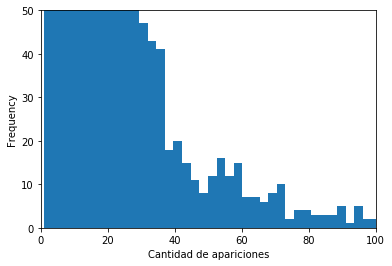

In [72]:
tg_unstack['0+1'].plot(kind='hist', bins=1000, xlim=(0,100), ylim=(0,50))#, x_label='Cantidad de apariciones')
plt.xlabel('Cantidad de apariciones')
#plt.axes.set_xlabel((0,50))
#plt.show()

In [38]:
tg_unstack['0+1'].describe()

count    31924.000000
mean         3.554097
std         31.040558
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       2575.000000
Name: 0+1, dtype: float64

### Me quedo con las palabras que aparecen más de 10 veces y cuyo delta/suma > 0.5

In [40]:
tg_unstack_n = tg_unstack[(tg_unstack['0+1'] > 10) & (tg_unstack['delta/suma'] > 0.5)]\
    .sort_values(by=['delta/suma', '0+1'], ascending=False)

In [41]:
tg_unstack_n

target,0,1,0+1,delta/suma
words,,,,
Northern,0.0,58.0,58.0,1.000000
bomber,0.0,56.0,56.0,1.000000
MH370:,0.0,39.0,39.0,1.000000
debris,0.0,37.0,37.0,1.000000
Investigators,0.0,36.0,36.0,1.000000
...,...,...,...,...
caught,5.0,16.0,21.0,0.523810
Over,5.0,16.0,21.0,0.523810
hostages,5.0,16.0,21.0,0.523810


### Grafico tg_unstack_n

Text(0.5, 0, 'n')

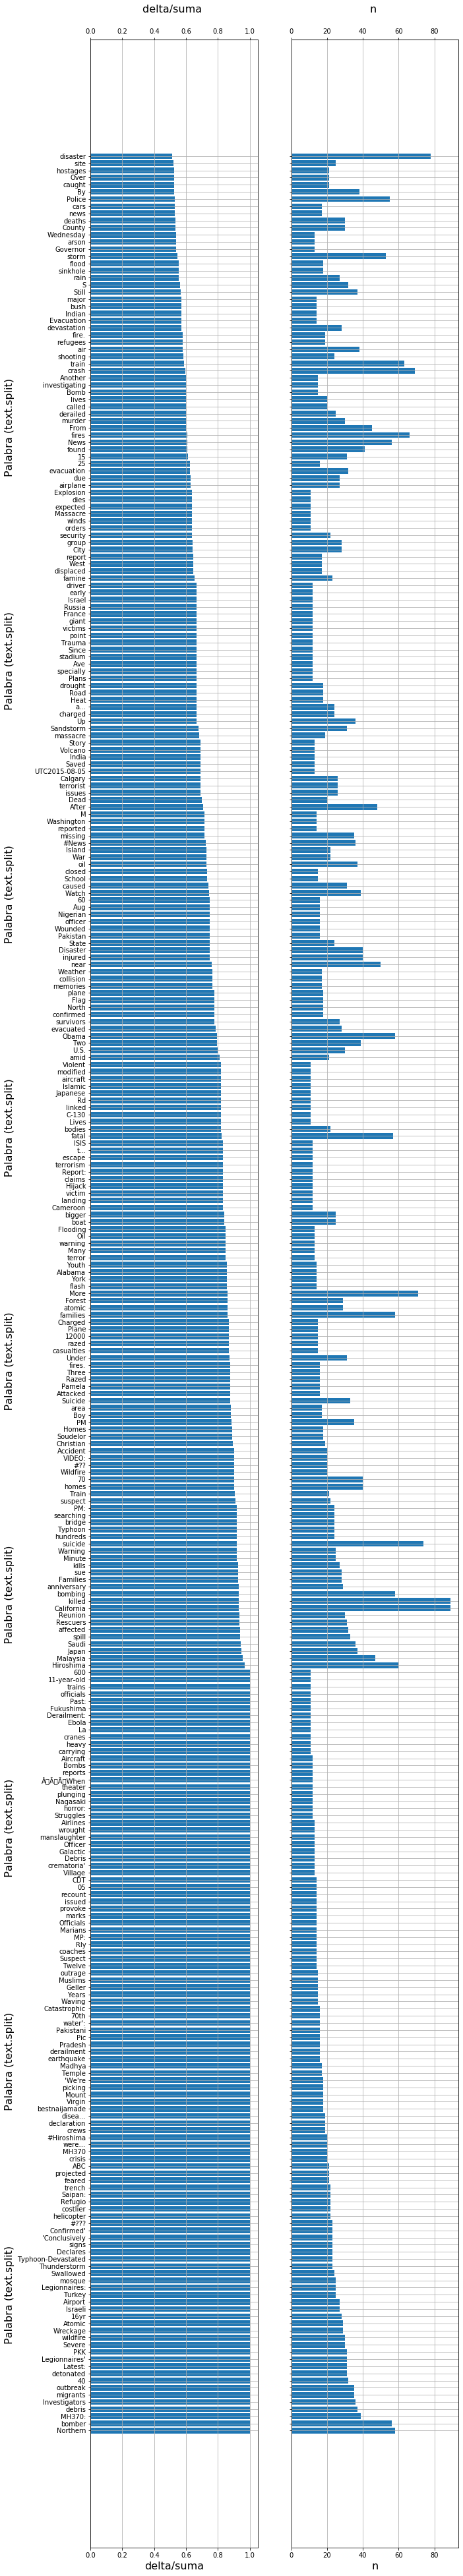

In [85]:
fig = plt.figure(figsize=(10,70))

ax1 = fig.add_subplot(121)
ax1.barh(tg_unstack_n.index, tg_unstack_n['delta/suma'])
ax1.grid()
ax1.set_title('delta/suma \n', fontsize=16)
ax1.secondary_xaxis('top')
ax1.set_ylabel(('Palabra (text.split)'+' '*40)*9, fontsize=16)
ax1.set_xlabel('delta/suma', fontsize=16)

ax2 = fig.add_subplot(122)
ax2.barh(tg_unstack_n.index, tg_unstack_n['0+1'], tick_label='')
ax2.grid()
ax2.set_title('n \n', fontsize=16)
ax2.secondary_xaxis('top')
ax2.set_xlabel('n', fontsize=16)

## Ejemplos

### Northern, California : Muchos tuits de incendio forestal en Northern California

In [66]:
train.loc[train['text'].str.contains('Northern'), 'text']

385     Los Angeles Times: Arson suspect linked to 30 ...
391     Arson suspect linked to 30 fires caught in Nor...
398     RelaxInPR: miprv: RT latimes: Arson suspect li...
408     Arson suspect linked to 30 fires caught in Nor...
410     Arson suspect linked to 30 fires caught in Nor...
                              ...                        
7315    @aria_ahrary @TheTawniest The out of control w...
7326    kc5kH mhtw4fnet\n\nCrews gaining on huge North...
7348    The Latest: More homes razed by Northern Calif...
7609    @aria_ahrary @TheTawniest The out of control w...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 61, dtype: object

In [ ]:
#train[train['text'].str.contains('Northern')].to_csv('northern.csv')

### Families, 40, outbreak, Legionnaires: "Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/02ELqLOpFk"

In [67]:
train.loc[train['text'].str.contains(' 40 '), 'text']

78      I-77 Mile Marker 31 to 40 South Mooresville  I...
3623    Understand that there are no fatalities as no ...
5264    Plains All American Pipeline company may have ...
5280    Families to sue over Legionnaires: More than 4...
5281    Families to sue over Legionnaires: More than 4...
5282    Families to sue over Legionnaires: More than 4...
5285    More than 40 families affected by the fatal ou...
5287    Families to sue over Legionnaires: More than 4...
5290    Families to sue over Legionnaires: More than 4...
5291    Families to sue over Legionnaires: More than 4...
5292    Families to sue over Legionnaires: More than 4...
5293    Families to sue over Legionnaires: More than 4...
5294    Families to sue over Legionnaires: More than 4...
5295    Families to sue over Legionnaires: More than 4...
5296    Families to sue over Legionnaires: More than 4...
5297    DTN Italy: Families to sue over Legionnaires: ...
5299    Families to sue over Legionnaires: More than 4...
5300    Famili

In [45]:
#train.loc[train['text'].str.contains(' 40 '), 'text'].to_csv('40.csv', index=False)

### PKK = partido d los trabajadores del Kurdistán

In [68]:
train.loc[train['text'].str.contains('PKK'), 'text']

1119    .@Vagersedolla visits villages recently bombed...
6363    #Bestnaijamade: 16yr old PKK suicide bomber wh...
6364    Pic of 16yr old PKK suicide bomber who detonat...
6365    Pic of 16yr old PKK suicide bomber who detonat...
6366    #Bestnaijamade: 16yr old PKK suicide bomber wh...
6368    Pic of 16yr old PKK suicide bomber who detonat...
6369    Pic of 16yr old PKK suicide bomber who detonat...
6370    ...//..// whao.. Pic of 16yr old PKK suicide b...
6373    #Bestnaijamade: 16yr old PKK suicide bomber wh...
6374    Pic of 16yr old PKK suicide bomber who detonat...
6375    See the 16yr old PKK suicide bomber who detona...
6376    //./../.. Pic of 16yr old PKK suicide bomber w...
6377    #Bestnaijamade: 16yr old PKK suicide bomber wh...
6378    #Bestnaijamade: 16yr old PKK suicide bomber wh...
6379    //./../.. Pic of 16yr old PKK suicide bomber w...
6380    recap/ Pic of 16yr old PKK suicide bomber who ...
6382    16yr old PKK suicide bomber who detonated bomb...
6383    16yr o